**Parcours Ingénieur Machine Learning**<br>
**Plus d'informations** : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning <br>

**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 18/08/2022<br>
**Accès projet git** : https://github.com/viczer/P8-Openclassroom_competition_Kaggle <br>
**Lien kernel Kaggle** : https://www.kaggle.com/code/victoriazeruk/amex-pytorch-gru-test?scriptVersionId=102969947

---


<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h2 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Project 8 : Participez a une competition Kaggle !
 </br>  | Notebook 4 : GRU model test | <br></h2> </div>    

<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h4 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center"> </h4> 
</div>   

# Time Series GRU PyTorch Training Notebook
This notebook is based on implementation of the [TensorFlow GRU Starter - [0.790]](https://www.kaggle.com/code/cdeotte/tensorflow-gru-starter-0-790/)

In this notebook we present starter code for a time series GRU model and starter code for processing Kaggle's 50GB CSV files into multiple saved NumPy files. Using a time series GRU allows us to use all the provided customer data and not just the customer's last data point. We published plots of time series data [here][1]. In this notebook we
* Processes the train data from dataframes into 3D NumPy array of dimensions `num_of_customers x 13 x 188`
* Save processed arrays as multiple NumPy files on disk
* Next we build and train a GRU from the multiple files on disk
* We compute validation score
* Finally we process and save test data, infer test, and create a submission


To view time series EDA which can help give you intuition about feature engineering and improving model architecture, see the notebook [here][1].

[1]: https://www.kaggle.com/cdeotte/time-series-eda

In [1]:
import os, copy, gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
print('Using PyTorch version',torch.__version__)

Using PyTorch version 1.11.0


# Process Train Data
We process both train and test data in chunks. We split train data into 10 parts and process each part separately and save to disk. We split test into 20 parts. This allows us to avoid memory errors during processing. We can also perform processing on GPU which is faster than CPU. Discussions about data preprocessing are [here][1] and [here][2]

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327828
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054

In [2]:
# LOADING JUST FIRST COLUMN OF TRAIN OR TEST IS SLOW
# INSTEAD YOU CAN LOAD FIRST COLUMN FROM MY DATASET
# OTHERWISE SET VARIABLE TO NONE TO LOAD FROM KAGGLE'S ORIGINAL DATAFRAME
PATH_TO_CUSTOMER_HASHES = '../input/amex-data-files/'

# AFTER PROCESSING DATA ONCE, UPLOAD TO KAGGLE DATASET
# THEN SET VARIABLE BELOW TO FALSE
# AND ATTACH DATASET TO NOTEBOOK AND PUT PATH TO DATASET BELOW
PROCESS_DATA = False
#PATH_TO_DATA = './data/'
PATH_TO_DATA = '../input/amex-data-for-transformers-and-rnns/data/'

# AFTER TRAINING MODEL, UPLOAD TO KAGGLE DATASET
# THEN SET VARIABLE BELOW TO FALSE
# AND ATTACH DATASET TO NOTEBOOK AND PUT PATH TO DATASET BELOW
TRAIN_MODEL = True
PATH_TO_MODEL = './model/'
#PATH_TO_MODEL = '../input/amex-data-for-transformers-and-rnns/model/'

INFER_TEST = True

In [3]:
import cupy, cudf # GPU LIBRARIES
import numpy as np, pandas as pd # CPU LIBRARIES
import matplotlib.pyplot as plt, gc

if PROCESS_DATA:
    # LOAD TARGETS
    targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
    targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    print(f'There are {targets.shape[0]} train targets')
    
    # GET TRAIN COLUMN NAMES
    train = cudf.read_csv('../input/amex-default-prediction/train_data.csv', nrows=1)
    T_COLS = train.columns
    print(f'There are {len(T_COLS)} train dataframe columns')
    
    # GET TRAIN CUSTOMER NAMES (use pandas to avoid memory error)
    if PATH_TO_CUSTOMER_HASHES:
        train = cudf.read_parquet(f'{PATH_TO_CUSTOMER_HASHES}train_customer_hashes.pqt')
    else:
        train = pd.read_csv('/raid/Kaggle/amex/train_data.csv', usecols=['customer_ID'])
        train['customer_ID'] = train['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    customers = train.drop_duplicates().sort_index().values.flatten()
    print(f'There are {len(customers)} unique customers in train.')

In [4]:
# CALCULATE SIZE OF EACH SEPARATE FILE
def get_rows(customers, train, NUM_FILES = 10, verbose = ''):
    chunk = len(customers)//NUM_FILES
    if verbose != '':
        print(f'We will split {verbose} data into {NUM_FILES} separate files.')
        print(f'There will be {chunk} customers in each file (except the last file).')
        print('Below are number of rows in each file:')
    rows = []

    for k in range(NUM_FILES):
        if k==NUM_FILES-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = train.loc[train.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows

if PROCESS_DATA:
    NUM_FILES = 10
    rows = get_rows(customers, train, NUM_FILES = NUM_FILES, verbose = 'train')

# Preprocess and Feature Engineering
The function below processes the data. Discussions describing the process are [here][1] and [here][2]. Currently the code below uses [RAPIDS][3] and GPU to
* Reduces memory usage of customer_ID column by converting to int64
* Reduces memory usage of date time column (then deletes the column).
* We fill NANs
* Label encodes the categorical columns
* We reduce memory usage dtypes of columns
* Converts every customer into a 3D array with sequence length 13 and feature length 188

To improve this model, try adding new feautures. The columns have been rearanged to have the 11 categorical features first. This makes building the TensorFlow model later easier. We can also try adding Standard Scaler. Currently the data is being used without scaling from the original Kaggle train data. 

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327828
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328054
[3]: https://rapids.ai/

In [5]:
def feature_engineer(train, PAD_CUSTOMER_TO_13_ROWS = True, targets = None):
        
    # REDUCE STRING COLUMNS 
    # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
    train['customer_ID'] = train['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    train.S_2 = cudf.to_datetime( train.S_2 )
    train['year'] = (train.S_2.dt.year-2000).astype('int8')
    train['month'] = (train.S_2.dt.month).astype('int8')
    train['day'] = (train.S_2.dt.day).astype('int8')
    del train['S_2']
        
    # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
    # with 0: padding, 1: nan, 2,3,4,etc: values
    d_63_map = {'CL':2, 'CO':3, 'CR':4, 'XL':5, 'XM':6, 'XZ':7}
    train['D_63'] = train.D_63.map(d_63_map).fillna(1).astype('int8')

    d_64_map = {'-1':2,'O':3, 'R':4, 'U':5}
    train['D_64'] = train.D_64.map(d_64_map).fillna(1).astype('int8')
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [2,1,2,2,3,2,3,2,2] #2 minus minimal value in full train csv
    # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
    for c,s in zip(CATS,OFFSETS):
        train[c] = train[c] + s
        train[c] = train[c].fillna(1).astype('int8')
    CATS += ['D_63','D_64']
    
    # ADD NEW FEATURES HERE
    # EXAMPLE: train['feature_189'] = etc etc etc
    # EXAMPLE: train['feature_190'] = etc etc etc
    # IF CATEGORICAL, THEN ADD TO CATS WITH: CATS += ['feaure_190'] etc etc etc
    
    # REDUCE MEMORY DTYPE
    SKIP = ['customer_ID','year','month','day']
    for c in train.columns:
        if c in SKIP: continue
        if str( train[c].dtype )=='int64':
            train[c] = train[c].astype('int32')
        if str( train[c].dtype )=='float64':
            train[c] = train[c].astype('float32')
            
    # PAD ROWS SO EACH CUSTOMER HAS 13 ROWS
    if PAD_CUSTOMER_TO_13_ROWS:
        tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
        more = cupy.array([],dtype='int64') 
        for j in range(1,13):
            i = tmp.loc[tmp==j].index.values
            more = cupy.concatenate([more,cupy.repeat(i,13-j)])
        df = train.iloc[:len(more)].copy().fillna(0)
        df = df * 0 - 1 #pad numerical columns with -1
        df[CATS] = (df[CATS] * 0).astype('int8') #pad categorical columns with 0
        df['customer_ID'] = more
        train = cudf.concat([train,df],axis=0,ignore_index=True)
        
    # ADD TARGETS (and reduce to 1 byte)
    if targets is not None:
        train = train.merge(targets,on='customer_ID',how='left')
        train.target = train.target.astype('int8')
        
    # FILL NAN
    train = train.fillna(-0.5) #this applies to numerical columns
    
    # SORT BY CUSTOMER THEN DATE
    train = train.sort_values(['customer_ID','year','month','day']).reset_index(drop=True)
    train = train.drop(['year','month','day'],axis=1)
    
    # REARRANGE COLUMNS WITH 11 CATS FIRST
    COLS = list(train.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    train = train[COLS]
    
    return train

In [6]:
if PROCESS_DATA:
    # CREATE PROCESSED TRAIN FILES AND SAVE TO DISK        
    for k in range(NUM_FILES):

        # READ CHUNK OF TRAIN CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        train = cudf.read_csv('../input/amex-default-prediction/train_data.csv', nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        train = feature_engineer(train, targets = targets)

        # SAVE FILES
        print(f'Train_File_{k+1} has {train.customer_ID.nunique()} customers and shape',train.shape)
        tar = train[['customer_ID','target']].drop_duplicates().sort_index()
        if not os.path.exists(PATH_TO_DATA): os.makedirs(PATH_TO_DATA)
        tar.to_parquet(f'{PATH_TO_DATA}targets_{k+1}.pqt',index=False)
        data = train.iloc[:,1:-1].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}data_{k+1}',data.astype('float32'))

    # CLEAN MEMORY
    del train, tar, data
    del targets
    gc.collect()

# Build Model
We will just input the sequence data into a basic GRU. We will follow that we two dense layers and finally a sigmoid output to predict default. Try improving the model architecture.

In [7]:
# SIMPLE GRU MODEL
class gru_model(nn.Module):
    def __init__(self, in_feats, hid_dim=256, activation=nn.ReLU()):
        super(gru_model, self).__init__()
        self.num_layers = 1
        self.hid_dim = hid_dim
        self.activation = activation
        self.hidden_state = None
        self.encode = nn.GRU(input_size=in_feats,
                             hidden_size=hid_dim,
                             num_layers=self.num_layers,
                             batch_first=True,
                             bidirectional=False)
        self.hidden = nn.Sequential(nn.Linear(hid_dim, 64),
                                    self.activation,
                                    nn.Linear(64, 32),
                                    self.activation)
        self.predict = nn.Linear(32, 2)
        
    def init_hidden(self, batch_size, device="cpu"):
        return torch.autograd.Variable(torch.zeros(self.num_layers, batch_size, self.hid_dim)).to(device)
    
    def forward(self, x):
        _, h = self.encode(x, self.hidden_state)
        h = self.hidden(torch.squeeze(h))
        return self.predict(h)

# Competition Metric Code
The code below is from Konstantin Yakovlev's discussion post [here][1]

[1]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534

In [8]:
# COMPETITION METRIC FROM Konstantin Yakovlev
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    print("G: {:.6f}, D: {:.6f}, ALL: {:6f}".format(gini[1]/gini[0], top_four, 0.5*(gini[1]/gini[0] + top_four)))
    return 0.5 * (gini[1]/gini[0] + top_four)

# Early Stopper

In [9]:
class early_stopper(object):
    def __init__(self, patience=12, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_value = None
        self.best_cv = None
        self.is_earlystop = False
        self.count = 0
        self.best_model = None
        #self.val_preds = []
        #self.val_logits = []

    def earlystop(self, loss, value, model=None):#, preds, logits):
        """
        value: evaluation value on valiation dataset
        """
        cv = value
        if self.best_value is None:
            self.best_value = value
            self.best_cv = cv
            self.best_model = copy.deepcopy(model).to('cpu')
            #self.val_preds = preds
            #self.val_logits = logits
        elif value < self.best_value + self.delta:
            self.count += 1
            if self.verbose:
                print('EarlyStoper count: {:02d}'.format(self.count))
            if self.count >= self.patience:
                self.is_earlystop = True
        else:
            self.best_value = value
            self.best_cv = cv
            self.best_model = copy.deepcopy(model).to('cpu')
            #self.val_preds = preds
            #self.val_logits = logits
            self.count = 0


# Train Model
We train 5 folds for 8 epochs each. We save the 5 fold models for test inference later. If you only want to infer without training, then set variable `TRAIN_MODEL = False` in the beginning of this notebook.

In [10]:
params = {
    'model': 'gru_model',
    'batch_size': 512,
    'lr': 0.002,
    'wd': 1e-5,
    #'device': 'cpu',
    'device': 'cuda:0',
    'early_stopping': 4,
    'n_fold': 5,
    'seed': 2021,
    'max_epochs': 20,
}

if TRAIN_MODEL:
    # SAVE TRUE AND OOF
    device = params['device']
    true = np.array([])
    oof = np.array([])

    for fold in range(5):

        # INDICES OF TRAIN AND VALID FOLDS
        valid_idx = [2*fold+1, 2*fold+2]
        train_idx = [x for x in [1,2,3,4,5,6,7,8,9,10] if x not in valid_idx]

        print('#'*25)
        print(f'### Fold {fold+1} with valid files', valid_idx)

        # READ TRAIN DATA FROM DISK
        X_train = []; y_train = []
        for k in train_idx:
            X_train.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_train.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_train = np.concatenate(X_train,axis=0)
        y_train = pd.concat(y_train).target.values
        print('### Training data shapes', X_train.shape, y_train.shape)

        # READ VALID DATA FROM DISK
        X_valid = []; y_valid = []
        for k in valid_idx:
            X_valid.append( np.load(f'{PATH_TO_DATA}data_{k}.npy'))
            y_valid.append( pd.read_parquet(f'{PATH_TO_DATA}targets_{k}.pqt') )
        X_valid = np.concatenate(X_valid,axis=0)
        y_valid = pd.concat(y_valid).target.values
        print('### Validation data shapes', X_valid.shape, y_valid.shape)
        print('#'*25)

        # TRAIN MODEL
        # loss_fn = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([118828, 340085])).float()).to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        train_sample_strategy = torch.utils.data.sampler.WeightedRandomSampler(np.ones(X_train.shape[0]),
                                                                               num_samples=X_train.shape[0], replacement=False)
        train_dataloader = torch.utils.data.DataLoader(np.array(range(X_train.shape[0])), batch_size=params['batch_size'], num_workers=0,
                                                       sampler=train_sample_strategy, drop_last=False)
        val_sample_strategy = torch.utils.data.sampler.WeightedRandomSampler(np.ones(X_valid.shape[0]),
                                                                             num_samples=X_valid.shape[0], replacement=False)
        val_dataloader = torch.utils.data.DataLoader(np.array(range(X_valid.shape[0])), batch_size=params['batch_size'], num_workers=0,
                                                     sampler=val_sample_strategy, drop_last=False)
        oof_predictions = torch.zeros(X_valid.shape[0], 2).float().to(device)
        model = eval(params['model'])(X_train.shape[-1]).to(device)
        lr = params['lr'] * np.sqrt(params['batch_size']/2048)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=params['wd'])
        lr_scheduler = MultiStepLR(optimizer=optimizer, milestones=[3600, 5000, 6000], gamma=0.1)
        earlystoper = early_stopper(patience=params['early_stopping'], verbose=True)
        start_epoch = 0
        for epoch in range(start_epoch, params['max_epochs']):
            train_loss_list = []
            # train_acc_list = []
            model.train()
            for step, input_seeds in enumerate(train_dataloader):
                batch_inputs = torch.from_numpy(X_train[input_seeds]).to(device)
                batch_labels = torch.from_numpy(y_train[input_seeds]).to(device).long()
                model.hidden_state = model.init_hidden(len(input_seeds), device)
                train_batch_logits = model(batch_inputs)
                train_loss = loss_fn(train_batch_logits, batch_labels)
                # backward
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
                lr_scheduler.step()
                train_loss_list.append(train_loss.cpu().detach().numpy())
                
                #tr_batch_pred = None

                if step % 50 == 0:
                    tr_batch_pred = torch.sum(torch.argmax(train_batch_logits.clone().detach(), dim=1) == batch_labels) / batch_labels.shape[0]
                    score = torch.softmax(train_batch_logits.clone().detach(), dim=1)[:, 1].cpu().numpy()
                    print('In epoch:{:03d}|batch:{:04d}, train_loss:{:4f}, '
                          'train_ap:{:.4f}, train_acc:{:.4f}, train_auc:{:.4f}'.format(epoch,step,
                                                                                       np.mean(train_loss_list),
                                                                                       average_precision_score(batch_labels.cpu().numpy(), score), 
                                                                                       tr_batch_pred.detach(),
                                                                                       roc_auc_score(batch_labels.cpu().numpy(), score)))
        
            # mini-batch for validation
            val_loss_list = 0
            val_acc_list = 0
            #val_correct_list = 0
            val_all_list = 0
            model.eval()
            with torch.no_grad():
                for step, input_seeds in enumerate(val_dataloader):
                    batch_inputs = torch.from_numpy(X_valid[input_seeds]).to(device)
                    batch_labels = torch.from_numpy(y_valid[input_seeds]).to(device).long()
                    model.hidden_state = model.init_hidden(len(input_seeds), device)
                    val_batch_logits = model(batch_inputs)
                    oof_predictions[input_seeds] = val_batch_logits
                    val_loss_list = val_loss_list + loss_fn(val_batch_logits, batch_labels)
                    val_batch_pred = torch.sum(torch.argmax(val_batch_logits, dim=1) == batch_labels) / torch.tensor(batch_labels.shape[0])
                    val_acc_list = val_acc_list + val_batch_pred * torch.tensor(batch_labels.shape[0])
                    val_all_list = val_all_list + batch_labels.shape[0]
                    if step % 50 == 0:
                        score = torch.softmax(val_batch_logits.clone().detach(), dim=1)[:, 1].cpu().numpy()
                        print('In epoch:{:03d}|batch:{:04d}, val_loss:{:4f}, val_ap:{:.4f}, '
                              'val_acc:{:.4f}, val_auc:{:.4f}'.format(epoch,
                                                                      step,
                                                                      val_loss_list/val_all_list,
                                                                      average_precision_score(batch_labels.cpu().numpy(), score), 
                                                                      val_batch_pred.detach(),
                                                                      roc_auc_score(batch_labels.cpu().numpy(), score)))
                #tmp_predictions = model(test_feature).cpu().numpy()
            #infold_preds[fold] = tmp_predictions
            #test_predictions += tmp_predictions / params['n_fold']
            val_predictions = torch.softmax(oof_predictions.detach(), dim=-1)[:, 1].cpu().numpy()
            earlystoper.earlystop(val_loss_list, amex_metric(y_valid, val_predictions), model)
            if earlystoper.is_earlystop:
                print("Early Stopping!")
                break
        print("Best val_metric is: {:.7f}".format(earlystoper.best_cv))
        if not os.path.exists(PATH_TO_MODEL): os.makedirs(PATH_TO_MODEL)
        torch.save(earlystoper.best_model.to('cpu').state_dict(), f'{PATH_TO_MODEL}gru_fold_{fold+1}.h5')

        # INFER VALID DATA
        print('Inferring validation data...')
        # mini-batch for validation
        val_loss_list = 0
        val_acc_list = 0
        #val_correct_list = 0
        val_all_list = 0
        model.load_state_dict(torch.load(f'{PATH_TO_MODEL}gru_fold_{fold+1}.h5'))
        model.eval()
        with torch.no_grad():
            for step, input_seeds in enumerate(val_dataloader):
                batch_inputs = torch.from_numpy(X_valid[input_seeds]).to(device)
                batch_labels = torch.from_numpy(y_valid[input_seeds]).to(device).long()
                model.hidden_state = model.init_hidden(len(input_seeds), device)
                val_batch_logits = model(batch_inputs)
                oof_predictions[input_seeds] = val_batch_logits
                val_loss_list = val_loss_list + loss_fn(val_batch_logits, batch_labels)
                val_batch_pred = torch.sum(torch.argmax(val_batch_logits, dim=1) == batch_labels) / torch.tensor(batch_labels.shape[0])
                val_acc_list = val_acc_list + val_batch_pred * torch.tensor(batch_labels.shape[0])
                val_all_list = val_all_list + batch_labels.shape[0]
                if step % 50 == 0:
                    score = torch.softmax(val_batch_logits.clone().detach(), dim=1)[:, 1].cpu().numpy()
                    print('In epoch:{:03d}|batch:{:04d}, val_loss:{:4f}, val_ap:{:.4f}, '
                          'val_acc:{:.4f}, val_auc:{:.4f}'.format(epoch,
                                                                  step,
                                                                  val_loss_list/val_all_list,
                                                                  average_precision_score(batch_labels.cpu().numpy(), score), 
                                                                  val_batch_pred.detach(),
                                                                  roc_auc_score(batch_labels.cpu().numpy(), score)))
        val_predictions = torch.softmax(oof_predictions.detach(), dim=-1)[:, 1].cpu().numpy()
        print()
        print(f'Fold {fold+1} CV=', amex_metric(y_valid, val_predictions) )
        print()
        true = np.concatenate([true, y_valid])
        oof = np.concatenate([oof, val_predictions])
        
        # CLEAN MEMORY
        del model, X_train, y_train, X_valid, y_valid
        gc.collect()

    # PRINT OVERALL RESULTS
    print('#'*25)
    print(f'Overall CV =', amex_metric(true, oof) )

#########################
### Fold 1 with valid files [1, 2]
### Training data shapes (367131, 13, 188) (367131,)
### Validation data shapes (91782, 13, 188) (91782,)
#########################
In epoch:000|batch:0000, train_loss:0.631196, train_ap:0.4643, train_acc:0.7715, train_auc:0.7099
In epoch:000|batch:0050, train_loss:0.365448, train_ap:0.8752, train_acc:0.8789, train_auc:0.9475
In epoch:000|batch:0100, train_loss:0.310467, train_ap:0.8593, train_acc:0.9121, train_auc:0.9533
In epoch:000|batch:0150, train_loss:0.288109, train_ap:0.9057, train_acc:0.9082, train_auc:0.9641
In epoch:000|batch:0200, train_loss:0.275844, train_ap:0.8839, train_acc:0.8867, train_auc:0.9502
In epoch:000|batch:0250, train_loss:0.267676, train_ap:0.9218, train_acc:0.9199, train_auc:0.9705
In epoch:000|batch:0300, train_loss:0.263178, train_ap:0.8938, train_acc:0.8828, train_auc:0.9571
In epoch:000|batch:0350, train_loss:0.260079, train_ap:0.8813, train_acc:0.9062, train_auc:0.9571
In epoch:000|batch:0400

# Process Test Data
We process the test data in the same way as train data.

In [11]:
if PROCESS_DATA:
    # GET TEST COLUMN NAMES
    test = cudf.read_csv('../input/amex-default-prediction/test_data.csv', nrows=1)
    T_COLS = test.columns
    print(f'There are {len(T_COLS)} test dataframe columns')
    
    # GET TEST CUSTOMER NAMES (use pandas to avoid memory error)
    if PATH_TO_CUSTOMER_HASHES:
        test = cudf.read_parquet(f'{PATH_TO_CUSTOMER_HASHES}test_customer_hashes.pqt')
    else:
        test = pd.read_csv('/raid/Kaggle/amex/test_data.csv', usecols=['customer_ID'])
        test['customer_ID'] = test['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    customers = test.drop_duplicates().sort_index().values.flatten()
    print(f'There are {len(customers)} unique customers in test.')

In [12]:
NUM_FILES = 20
if PROCESS_DATA:
    # CALCULATE SIZE OF EACH SEPARATE FILE
    rows = get_rows(customers, test, NUM_FILES = NUM_FILES, verbose = 'test')

In [13]:
if PROCESS_DATA:
    # SAVE TEST CUSTOMERS INDEX
    test_customer_hashes = cupy.array([],dtype='int64')
    
    # CREATE PROCESSED TEST FILES AND SAVE TO DISK
    for k in range(NUM_FILES):

        # READ CHUNK OF TEST CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        test = cudf.read_csv('../input/amex-default-prediction/test_data.csv', nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        test = feature_engineer(test, targets = None)
        
        # SAVE TEST CUSTOMERS INDEX
        cust = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
        test_customer_hashes = cupy.concatenate([test_customer_hashes,cust])

        # SAVE FILES
        print(f'Test_File_{k+1} has {test.customer_ID.nunique()} customers and shape',test.shape)
        data = test.iloc[:,1:].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}test_data_{k+1}',data.astype('float32'))
        
    # SAVE CUSTOMER INDEX OF ALL TEST FILES
    cupy.save(f'{PATH_TO_DATA}test_hashes_data', test_customer_hashes)

    # CLEAN MEMORY
    del test, data
    gc.collect()

# Infer Test Data
We infer the test data from our saved fold models. If you don't wish to infer test but you only want your notebook to compute a validation score to evaluate model changes, then set variable `INFER_TEST = False` in the beginning of this notebook. Also if you wish to infer from previously trained models, then add the path to the Kaggle dataset in the variable `PATH_TO_MODEL` in the beginning of this notebook.

In [14]:
if INFER_TEST:
    # INFER TEST DATA
    start = 0; end = 0
    sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
    NUM_FILES = 20
    # REARANGE SUB ROWS TO MATCH PROCESSED TEST FILES
    sub['hash'] = sub['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype('int64')
    test_hash_index = np.load(f'{PATH_TO_DATA}test_hashes_data.npy')
    sub = sub.set_index('hash').loc[test_hash_index].reset_index(drop=True)
    
    for k in range(NUM_FILES):
        # LOAD TEST DATA
        print(f'Inferring Test_File_{k+1}')
        X_test = np.load(f'{PATH_TO_DATA}test_data_{k+1}.npy')
        end = start + X_test.shape[0]

        # BUILD MODEL
        model = eval(params['model'])(X_test.shape[-1]).to(device)
        
        # INFER 5 FOLD MODELS
        model.load_state_dict(torch.load(f'{PATH_TO_MODEL}gru_fold_1.h5'))
        test_predictions = torch.zeros(X_test.shape[0], 2).to(device).float()
        test_sample_strategy = torch.utils.data.sampler.WeightedRandomSampler(np.ones(X_test.shape[0]),
                                                                              num_samples=X_test.shape[0], replacement=False)
        test_dataloader = torch.utils.data.DataLoader(np.array(range(X_test.shape[0])), batch_size=params['batch_size'], num_workers=0,
                                                      sampler=test_sample_strategy, drop_last=False)
        
        for j in range(1,5):
            model.load_state_dict(torch.load(f'{PATH_TO_MODEL}gru_fold_{j+1}.h5'))
            with torch.no_grad():
                for step, input_seeds in enumerate(test_dataloader):
                    batch_inputs = torch.from_numpy(X_test[input_seeds]).to(device).float()
                    model.hidden_state = model.init_hidden(len(input_seeds), device)
                    test_batch_logits = model(batch_inputs)
                    test_predictions[input_seeds] = test_predictions[input_seeds] + torch.softmax(test_batch_logits, dim=-1)
                    #test_batch_pred = torch.sum(torch.argmax(test_batch_logits, dim=1) == batch_labels) / torch.tensor(batch_labels.shape[0])
                    if step % 50 == 0:
                        print('In fold {} test batch:{:04d}'.format(j+1, step))
        test_predictions /= 5.0

        # SAVE TEST PREDICTIONS
        sub.loc[start:end-1,'prediction'] = test_predictions[:, 1].cpu().numpy()
        start = end
        
        # CLEAN MEMORY
        del model, X_test
        gc.collect()


Inferring Test_File_1
In fold 2 test batch:0000
In fold 2 test batch:0050
In fold 3 test batch:0000
In fold 3 test batch:0050
In fold 4 test batch:0000
In fold 4 test batch:0050
In fold 5 test batch:0000
In fold 5 test batch:0050
Inferring Test_File_2
In fold 2 test batch:0000
In fold 2 test batch:0050
In fold 3 test batch:0000
In fold 3 test batch:0050
In fold 4 test batch:0000
In fold 4 test batch:0050
In fold 5 test batch:0000
In fold 5 test batch:0050
Inferring Test_File_3
In fold 2 test batch:0000
In fold 2 test batch:0050
In fold 3 test batch:0000
In fold 3 test batch:0050
In fold 4 test batch:0000
In fold 4 test batch:0050
In fold 5 test batch:0000
In fold 5 test batch:0050
Inferring Test_File_4
In fold 2 test batch:0000
In fold 2 test batch:0050
In fold 3 test batch:0000
In fold 3 test batch:0050
In fold 4 test batch:0000
In fold 4 test batch:0050
In fold 5 test batch:0000
In fold 5 test batch:0050
Inferring Test_File_5
In fold 2 test batch:0000
In fold 2 test batch:0050
In fol

# Create Submission

In [15]:
if INFER_TEST:
    sub.to_csv('submission.csv',index=False)
    print('Submission file shape is', sub.shape )
    display( sub.head() )

Submission file shape is (924621, 2)


,customer_ID,prediction
0,038be0571bd6b3776cb8512731968f4de302c811030124...,0.002693
1,0074a0233ef766b52884608cc8cf9098f59d885b5d59fc...,0.000180
2,060b8b7f30f795a0e93995d45b29461ffa6ece0eeb5c3d...,0.116437
3,03a1d125bdd776000bf0b28238d0bea240ad581d332e70...,0.101910
4,0290f245dd35ba899af52316ccc62b2627e7ae18cd76a2...,0.263011


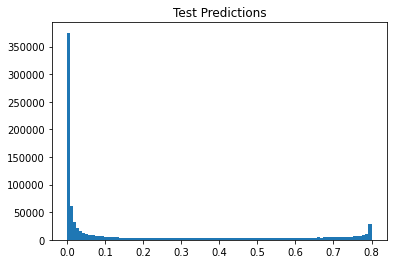

In [16]:
if INFER_TEST:
    # DISPLAY SUBMISSION PREDICTIONS
    plt.hist(sub.prediction, bins=100)
    plt.title('Test Predictions')
    plt.show()